# Image classifier

In [1]:
!pip install torch
!pip install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [35]:
import torch
import torchvision
from torchvision import transforms
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report,accuracy_score,f1_score
from sklearn.model_selection import GridSearchCV,cross_validate,train_test_split
from sklearn.naive_bayes import GaussianNB,MultinomialNB,ComplementNB,BernoulliNB,CategoricalNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, StackingClassifier,BaggingClassifier,AdaBoostClassifier,RandomForestClassifier,GradientBoostingClassifier
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from skimage.filters import sobel,laplace,prewitt
from sklearn.neighbors import KNeighborsClassifier

## Dataset

In [17]:
transformer = transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ])

In [37]:
train_set=torchvision.datasets.FashionMNIST('./files/fashion-mnist/', train=True, download=True,
                             transform=transformer)

test_set=torchvision.datasets.FashionMNIST('./files/fashion-mnist/', train=False, download=True,
                             transform=transformer)

batch_size_train= len(train_set)
batch_size_test=len(test_set)

In [38]:
train_loader = torch.utils.data.DataLoader(
  train_set,
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  test_set,
  batch_size=batch_size_test, shuffle=True)

In [39]:
train_enumerated = enumerate(train_loader)
batch_idx, (train_x, train_y) = next(train_enumerated)

test_enumerated = enumerate(test_loader)
batch_idx, (test_x, test_y) = next(test_enumerated)

In [40]:
train_x.shape

torch.Size([60000, 1, 28, 28])

In [41]:
train_x[1].shape

torch.Size([1, 28, 28])

In [42]:
classes = [ 'T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
'Ankle boot']

In [43]:
def print_white_black_image(images,ys):
    num_row = 3
    num_col = 5
    
    images = [img[0, :, :] for img in images]
    labels = [classes[label] for label in ys]

    # plot images
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(num_row*num_col):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(images[i], cmap='gray')
        ax.set_title('Label: {}'.format(labels[i]))
    plt.tight_layout()
    plt.show()

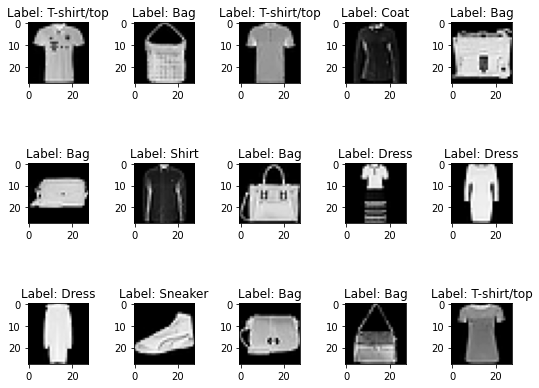

In [44]:
print_white_black_image(train_x[:15],train_y[:15])

## Preprocessing

We will use edge detecting filters.

In [45]:
def apply_filter(images,curr_filter):
    return [curr_filter(img) for img in images]

#### Sobel

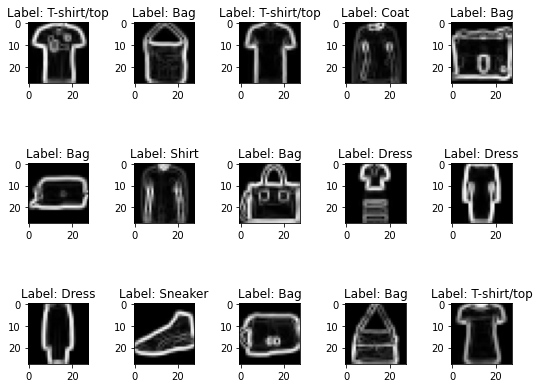

In [46]:
sobel_im = apply_filter(train_x[:15],sobel)
print_white_black_image(sobel_im,train_y[:15])

#### Laplace

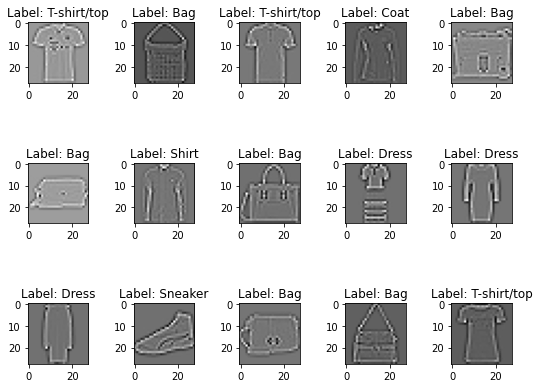

In [47]:
laplace_im = apply_filter(train_x[:15],laplace)
print_white_black_image(laplace_im,train_y[:15])

#### Prewitt

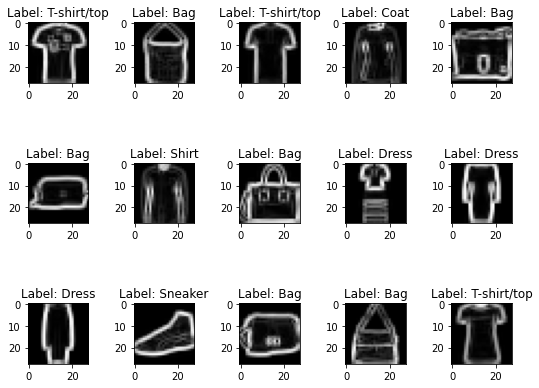

In [48]:
prewitt_im = apply_filter(train_x[:15],prewitt)
print_white_black_image(prewitt_im,train_y[:15])

The results from Sobel and Prewitt are really close and good whereas the images with Laplace filter are really blurry. We will use the sobel filter.

In [49]:
sobel_train_x = apply_filter(train_x,sobel) 
sobel_train_x = [torch.flatten(torch.Tensor(img)).numpy() for img in sobel_train_x]
sobel_test_x = apply_filter(test_x,sobel) 
sobel_test_x = [torch.flatten(torch.Tensor(img)).numpy() for img in sobel_test_x]
train_x = [torch.flatten(torch.Tensor(img)).numpy() for img in train_x]
test_x = [torch.flatten(torch.Tensor(img)).numpy() for img in test_x]

In [50]:
train_x[1].shape

(784,)

In [51]:
sobel_train_x[1].shape

(784,)

In [52]:
train_x[1]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00784314,
       0.        , 0.        , 0.29803923, 0.49411765, 0.5176471 ,
       0.44705883, 0.        , 0.        , 0.01960784, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00392157, 0.        , 0.        , 0.5568628 ,
       0.5411765 , 0.        , 0.        , 0.33333334, 0.5411765 ,
       0.12941177, 0.        , 0.01568628, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00392157, 0.        ,
       0.        , 0.39215687, 0.29803923, 0.        , 0.        ,
       0.        , 0.        , 0.02745098, 0.5803922 , 0.21960

In [53]:
sobel_train_x[1]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00080049, 0.00339618, 0.00178994,
       0.11047879, 0.28508574, 0.1553192 , 0.18305089, 0.2387827 ,
       0.1489723 , 0.2735956 , 0.1324195 , 0.02242792, 0.00865859,
       0.00320195, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00080049,
       0.00160097, 0.00080049, 0.07765135, 0.25517833, 0.17398395,
       0.17497551, 0.28861964, 0.29896873, 0.21732149, 0.04804255,
       0.23651645, 0.18335867, 0.04483441, 0.0064039 , 0.00320195,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00160097, 0.00253136, 0.00080049, 0.07444528,
       0.21376747, 0.12580894, 0.21034534, 0.2866246 , 0.10969299,
       0.06747397, 0.18733788, 0.2568665 , 0.06622789, 0.22215

## Models
### Testing the models on the dataset

We will stack our best classifiers and use the results as a reference in the tests.

In [54]:
bnb = BernoulliNB(alpha=0, binarize=0.05)
knn = KNeighborsClassifier(n_neighbors=5)
svc = SVC(kernel='rbf', gamma=0.02, C=1)
lr = LogisticRegression(solver='saga', multi_class='ovr', penalty='l1', n_jobs=-1, C = 0.7)
clf = StackingClassifier(estimators=[('bnb', bnb),('svc',svc), ('knn', knn), ('lr',lr)], final_estimator=LogisticRegression(random_state=0))

clf.fit(train_x, train_y)
pred = clf.predict(test_x)

print (f'Stacked models F1 score = {f1_score(test_y, pred,average="micro")*100}')
print (f'Stacked models Classification Report \n {classification_report(test_y, pred, labels=range(0,10))}')

Stacked models F1 score = 88.69
Stacked models Classification Report 
               precision    recall  f1-score   support

           0       0.83      0.85      0.84      1000
           1       0.99      0.97      0.98      1000
           2       0.80      0.82      0.81      1000
           3       0.88      0.89      0.89      1000
           4       0.81      0.82      0.82      1000
           5       0.97      0.96      0.96      1000
           6       0.73      0.66      0.69      1000
           7       0.93      0.96      0.95      1000
           8       0.95      0.98      0.97      1000
           9       0.97      0.95      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



### Testing the models on the preprocessed dataset

In [ ]:
bnb = BernoulliNB(alpha=0, binarize=0.05)
knn = KNeighborsClassifier(n_neighbors=5)
svc = SVC(kernel='rbf', gamma=0.02, C=1)
lr = LogisticRegression(solver='saga', multi_class='ovr', penalty='l1', n_jobs=-1, C = 0.7)
clf = StackingClassifier(estimators=[('bnb', bnb),('svc',svc), ('knn', knn), ('lr',lr)], final_estimator=LogisticRegression(random_state=0))

clf.fit(sobel_train_x, train_y)
pred = clf.predict(sobel_test_x)

print (f'Stacked models F1 score on sobel filtered images = {f1_score(test_y, pred,average="micro")*100}')
print (f'Stacked models Classification Report on sobel filtered images \n {classification_report(test_y, pred, labels=range(0,10))}')

As we can see the edge detection filters do not improve the performance of our models. That is why we will not use them for future experiments. However, the filter improved the training time drastically.

### Dimension reduction
#### PCA

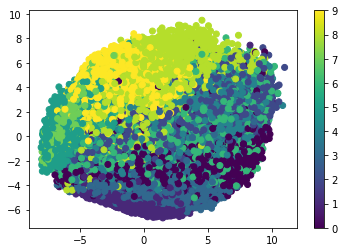

In [56]:
pca = PCA(n_components=50)
pca.fit(train_x)
pca_train_x = pca.transform(train_x)
pca_test_x = pca.transform(test_x)

# plot the PCA results
plt.scatter(pca_train_x[:, 0], pca_train_x[:, 1], c=train_y)
plt.colorbar()
plt.show()

In [ ]:
bnb = BernoulliNB(alpha=0, binarize=0.05)
knn = KNeighborsClassifier(n_neighbors=5)
svc = SVC(kernel='rbf', gamma=0.02, C=1)
lr = LogisticRegression(solver='saga', multi_class='ovr', penalty='l1', n_jobs=-1, C = 0.7)
clf = StackingClassifier(estimators=[('bnb', bnb),('svc',svc), ('knn', knn), ('lr',lr)], final_estimator=LogisticRegression(random_state=0))

clf.fit(pca_train_x, train_y)
pred = clf.predict(pca_test_x)

print (f'Stacked models F1 score on sobel filtered images = {f1_score(test_y, pred,average="micro")*100}')
print (f'Stacked models Classification Report on sobel filtered images \n {classification_report(test_y, pred, labels=range(0,10))}')

In [ ]:
def find_best_pca_param(comp_number):
    pca = PCA(n_components=comp_number)
    pca.fit(train_x)
    pca_train_x = pca.transform(train_x)
    pca_test_x = pca.transform(test_x)

    bnb = BernoulliNB(alpha=0, binarize=0.05)
    lr= LogisticRegression(n_jobs=-1,random_state=1)
    svc = SVC(kernel='rbf', gamma=0.02, C=1)
    clf = StackingClassifier(estimators=[('bnb', bnb),('svc',svc), ('lr', lr)], final_estimator=LogisticRegression(random_state=0))

    clf.fit(pca_train_x, train_y)
    pred = clf.predict(pca_test_x)
    
    return f1_score(test_y, pred,average="micro")*100

In [ ]:
scores=[]
    
for k in range(1,250,10):
    scores.append(find_best_pca_param(k))


plt.figure(figsize=(10, 6))
plt.plot(range(1,250,10), scores, color='green', label='test score')
plt.legend()

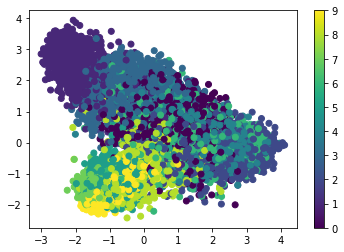

In [ ]:
pca = PCA(n_components=180)
pca.fit(train_x)
pca_train_x = pca.transform(train_x)
pca_test_x = pca.transform(test_x)

# plot the PCA results
plt.scatter(pca_train_x[:, 0], pca_train_x[:, 1], c=train_y)
plt.colorbar()
plt.show()

In [ ]:
bnb = BernoulliNB(alpha=0, binarize=0.05)
knn = KNeighborsClassifier(n_neighbors=5)
svc = SVC(kernel='rbf', gamma=0.02, C=1)
lr = LogisticRegression(solver='saga', multi_class='ovr', penalty='l1', n_jobs=-1, C = 0.7)
clf = StackingClassifier(estimators=[('bnb', bnb),('svc',svc), ('knn', knn), ('lr',lr)], final_estimator=LogisticRegression(random_state=0))

clf.fit(pca_train_x, train_y)
pred = clf.predict(pca_test_x)

LogisticRegression(n_jobs=-1)

In [ ]:
print (f'Stacked models F1 score = {f1_score(test_y, pred,average="micro")*100}')
print (f'Stacked models Classification Report \n {classification_report(test_y, pred, labels=range(0,10))}')

This PCA improves our results.

#### T-distributed Stochastic Neighbor Embedding 

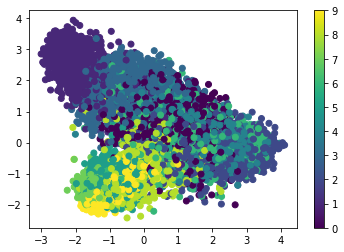

In [ ]:
tsne = TSNE()
tsne.fit(train_x)
tsne_train_x = tsne.transform(train_x)
tsne_test_x = tsne.transform(test_x)

plt.scatter(tsne_train_x[:, 0], tsne_train_x[:, 1], c=train_y)
plt.colorbar()
plt.show()

In [ ]:
bnb = BernoulliNB(alpha=0, binarize=0.05)
knn = KNeighborsClassifier(n_neighbors=5)
svc = SVC(kernel='rbf', gamma=0.02, C=1)
lr = LogisticRegression(solver='saga', multi_class='ovr', penalty='l1', n_jobs=-1, C = 0.7)
clf = StackingClassifier(estimators=[('bnb', bnb),('svc',svc), ('knn', knn), ('lr',lr)], final_estimator=LogisticRegression(random_state=0))

clf.fit(tsne_train_x, train_y)
pred = clf.predict(tsne_test_x)

In [ ]:
print (f'Stacked models F1 score on sobel filtered images = {f1_score(test_y, pred,average="micro")*100}')
print (f'Stacked models Classification Report on sobel filtered images \n {classification_report(test_y, pred, labels=range(0,10))}')

LogisticRegression(n_jobs=-1)

## Comparing ensemble algorithms

In [ ]:
bnb = BernoulliNB(alpha=0, binarize=0.05)
knn = KNeighborsClassifier(n_neighbors=5)
svc = SVC(kernel='rbf', gamma=0.02, C=1)
lr = LogisticRegression(solver='saga', multi_class='ovr', penalty='l1', n_jobs=-1, C = 0.7)
clf = StackingClassifier(estimators=[('bnb', bnb),('svc',svc), ('knn', knn), ('lr',lr)], final_estimator=LogisticRegression(random_state=0))

### Voting

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy', max_features='auto', random_state=1, splitter='best',max_depth=None)
lr = LogisticRegression(C=0.1, dual=False, penalty='l2', random_state=1)
svc = SVC(C=2, kernel='rbf', random_state=1)
gnb = GaussianNB(var_smoothing=0)
voting = VotingClassifier(estimators=[('dt', dt), ('lr', lr), ('svc', svc), ('gnb', gnb)], voting='hard')

In [ ]:
voting.fit(pca_train_x, train_y)
pred = voting.predict(pca_test_x)

print (f'Voting classifier F1 score on test data = {f1_score(test_y, pred,average="micro")*100}')
print (f'Voting classifier Classification Report \n {classification_report(test_y, pred, labels=range(0,10))}')

Voting classifier F1 score on test data = 33.4
Voting classifier Classification Report 
               precision    recall  f1-score   support

           0       0.39      0.45      0.42       108
           1       0.35      0.43      0.38       116
           2       0.29      0.40      0.33        93
           3       0.30      0.15      0.20       117
           4       0.33      0.46      0.38        89
           5       0.26      0.18      0.21        95
           6       0.28      0.27      0.27        93
           7       0.36      0.31      0.33       103
           8       0.33      0.42      0.37        86
           9       0.43      0.30      0.36       100

    accuracy                           0.33      1000
   macro avg       0.33      0.34      0.33      1000
weighted avg       0.33      0.33      0.33      1000



### Bagging

In [ ]:
svc = SVC(C=2, kernel='rbf', random_state=1)
bagging = BaggingClassifier(base_estimator=svc, n_estimators=50, random_state=1)

In [ ]:
bagging.fit(pca_train_x, train_y)
pred = bagging.predict(pca_test_x)

print (f'Bagging classifier F1 score on test data = {f1_score(test_y, pred,average="micro")*100}')
print (f'Bagging classifier Classification Report \n {classification_report(test_y, pred, labels=range(0,10))}')

Bagging classifier F1 score on test data = 37.6
Bagging classifier Classification Report 
               precision    recall  f1-score   support

           0       0.46      0.48      0.47       108
           1       0.40      0.42      0.41       116
           2       0.34      0.35      0.35        93
           3       0.37      0.22      0.28       117
           4       0.36      0.49      0.42        89
           5       0.28      0.22      0.25        95
           6       0.35      0.40      0.37        93
           7       0.39      0.30      0.34       103
           8       0.40      0.45      0.43        86
           9       0.36      0.44      0.40       100

    accuracy                           0.38      1000
   macro avg       0.37      0.38      0.37      1000
weighted avg       0.37      0.38      0.37      1000



### Boosting

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy', max_features='auto', random_state=1, splitter='best',max_depth=None)
boosting = AdaBoostClassifier(base_estimator=dt, n_estimators=50, random_state=1)

In [ ]:
boosting.fit(pca_train_x, train_y)
pred = boosting.predict(pca_test_x)

print (f'Boosting classifier F1 score on test data = {f1_score(test_y, pred,average="micro")*100}')
print (f'Boosting classifier Classification Report \n {classification_report(test_y, pred, labels=range(0,10))}')

Boosting classifier F1 score on test data = 19.2
Boosting classifier Classification Report 
               precision    recall  f1-score   support

           0       0.21      0.19      0.20       108
           1       0.26      0.27      0.26       116
           2       0.16      0.15      0.15        93
           3       0.25      0.21      0.23       117
           4       0.14      0.16      0.15        89
           5       0.18      0.18      0.18        95
           6       0.14      0.13      0.13        93
           7       0.18      0.19      0.19       103
           8       0.19      0.23      0.21        86
           9       0.19      0.18      0.18       100

    accuracy                           0.19      1000
   macro avg       0.19      0.19      0.19      1000
weighted avg       0.19      0.19      0.19      1000



### Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=50, random_state=1)

In [ ]:
rf.fit(pca_train_x, train_y)
pred = rf.predict(pca_test_x)

print (f'Random Forest Classifier F1 score on test data = {f1_score(test_y, pred,average="micro")*100}')
print (f'Random Forest Classifier Classification Report \n {classification_report(test_y, pred, labels=range(0,10))}')

Random Forest Classifier F1 score on test data = 30.8
Random Forest Classifier Classification Report 
               precision    recall  f1-score   support

           0       0.48      0.38      0.42       108
           1       0.37      0.43      0.40       116
           2       0.30      0.34      0.32        93
           3       0.19      0.10      0.13       117
           4       0.30      0.34      0.32        89
           5       0.24      0.25      0.25        95
           6       0.27      0.33      0.30        93
           7       0.33      0.26      0.29       103
           8       0.29      0.40      0.34        86
           9       0.28      0.27      0.28       100

    accuracy                           0.31      1000
   macro avg       0.30      0.31      0.30      1000
weighted avg       0.31      0.31      0.30      1000



#### Stacking

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy', max_features='auto', random_state=1, splitter='best',max_depth=None)
lr = LogisticRegression(C=0.1, dual=False, penalty='l2', random_state=1)
svc = SVC(C=2, kernel='rbf', random_state=1)
gnb = GaussianNB(var_smoothing=0)
clf = StackingClassifier(estimators=[('gnb', gnb), ('lr', lr),('svc',svc),('dt',dt)], final_estimator=LogisticRegression(random_state=0))

In [ ]:
batch_size_train= len(train_set)
batch_size_test=len(test_set)

In [ ]:
train_loader = torch.utils.data.DataLoader(
  train_set,
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  test_set,
  batch_size=batch_size_test, shuffle=True)

In [ ]:
train_enumerated = enumerate(train_loader)
batch_idx, (train_x, train_y) = next(train_enumerated)

test_enumerated = enumerate(test_loader)
batch_idx, (test_x, test_y) = next(test_enumerated)

In [ ]:
sobel_after_mcc_train_x = [apply_sobel_after_mean_color(img) for img in train_x]
sobel_after_mcc_test_x = [apply_sobel_after_mean_color(img) for img in test_x]

In [ ]:
pca = PCA(n_components=36)
pca.fit(sobel_after_mcc_train_x)
pca_train_x = pca.transform(sobel_after_mcc_train_x)
pca_test_x = pca.transform(sobel_after_mcc_test_x)

In [ ]:
clf.fit(pca_train_x, train_y)
pred = clf.predict(pca_test_x)

print (f'Stacked models F1 score on test data = {f1_score(test_y, pred,average="micro")*100}')
print (f'Stacked models Classification Report \n {classification_report(test_y, pred, labels=range(0,10))}')

Stacked models F1 score on test data = 43.080000000000005
Stacked models Classification Report 
               precision    recall  f1-score   support

           0       0.51      0.50      0.51      1000
           1       0.48      0.53      0.50      1000
           2       0.41      0.35      0.38      1000
           3       0.31      0.11      0.16      1000
           4       0.40      0.43      0.41      1000
           5       0.35      0.33      0.34      1000
           6       0.42      0.55      0.48      1000
           7       0.47      0.50      0.48      1000
           8       0.46      0.53      0.49      1000
           9       0.42      0.48      0.45      1000

    accuracy                           0.43     10000
   macro avg       0.42      0.43      0.42     10000
weighted avg       0.42      0.43      0.42     10000



#### Bagging

In [ ]:
svc = SVC(C=2, kernel='rbf', random_state=1)
bagging = BaggingClassifier(base_estimator=svc, n_estimators=100, random_state=1)

bagging.fit(pca_train_x, train_y)
pred = bagging.predict(pca_test_x)

In [ ]:
print (f'Bagging model F1 score on test data = {f1_score(test_y, pred,average="micro")*100}')
print (f'Bagging model Classification Report \n {classification_report(test_y, pred, labels=range(0,10))}')

Bagging model F1 score on test data = 73.75
Bagging model Classification Report 
               precision    recall  f1-score   support

           0       0.78      0.79      0.79      1000
           1       0.83      0.84      0.84      1000
           2       0.69      0.63      0.66      1000
           3       0.75      0.64      0.69      1000
           4       0.55      0.69      0.61      1000
           5       0.78      0.66      0.72      1000
           6       0.61      0.75      0.68      1000
           7       0.84      0.76      0.80      1000
           8       0.76      0.79      0.78      1000
           9       0.87      0.81      0.84      1000

    accuracy                           0.74     10000
   macro avg       0.75      0.74      0.74     10000
weighted avg       0.75      0.74      0.74     10000



### Final tests of the base models

#### SVC

In [ ]:
svc = SVC(C=2, kernel='rbf', random_state=1)
svc.fit(pca_train_x, train_y)

SVC(C=2, random_state=1)

In [ ]:
pred = svc.predict(pca_test_x)

In [ ]:
print (f'SVC F1 score on test data = {f1_score(test_y, pred,average="micro")*100}')
print (f'SVC Classification Report \n {classification_report(test_y, pred, labels=range(0,10))}')

SVC F1 score on test data = 70.48
SVC Classification Report 
               precision    recall  f1-score   support

           0       0.77      0.77      0.77      1000
           1       0.82      0.80      0.81      1000
           2       0.67      0.58      0.62      1000
           3       0.69      0.60      0.64      1000
           4       0.52      0.67      0.59      1000
           5       0.73      0.63      0.67      1000
           6       0.59      0.73      0.65      1000
           7       0.80      0.73      0.77      1000
           8       0.73      0.75      0.74      1000
           9       0.82      0.78      0.80      1000

    accuracy                           0.70     10000
   macro avg       0.71      0.70      0.71     10000
weighted avg       0.71      0.70      0.71     10000



#### KNN

In [ ]:
.....................

# Final Results

In [ ]:
data = {'Model':  ['SVC without tuning and preprocessing', 'Stacking model','SVC', 'Bagging model','CNN'],
        'F1 Score': [44.760000000000005,43.080000000000005 ,70.48,73.75,69.61],
        }

df = pd.DataFrame(data)
print(df)

                                  Model  F1 Score
0  SVC without tuning and preprocessing     44.76
1                        Stacking model     43.08
2                                   SVC     70.48
3                         Bagging model     73.75
4                                   CNN     69.61


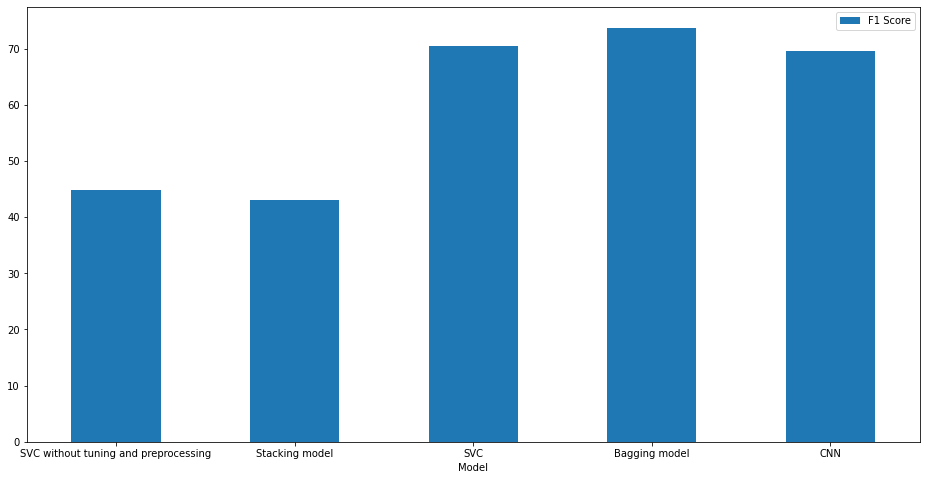

In [ ]:
barplot = df.plot.bar(x='Model', y='F1 Score', rot=0, figsize=(16,8))

### Conclusion

As we can see the preprocessing dramatically imporves the results of the algorithms. The machine learning algorithms might not be the best choice for image classification. However, with good feature extraction and parameters tuning they can do a pretty good job on complex datasets like CIFAR-10.